In [1]:

import psycopg2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt


import seaborn as sns
import datetime

from Ignore import db_cred
conn = db_cred.connect_db()

Query from SQL Database to creat Dataframes
(All Data Frames are 1947-2016)

df1 = All Pitchers
df2 = All-Star Pitchers
df3 = Starting Pithers: more than 20 Games Started per season, 
df4 = All-Star Starting Pitchers: more than 20 Games Started per season, 
df5 = All Relief Pitchers: < 5 Games Started and > 50 Innings Pitcher per season
df6 = All-Star Relief Pitchers: All-Stars w/ < 5 Games Started and > 50 Innings Pitcher per season

In [2]:
query = '''
SELECT * 
FROM pitching AS p
WHERE p."yearID" >= '1947'
ORDER BY p."yearID" DESC, p."teamID" DESC, p."playerID" DESC;
'''


df1 = pd.read_sql(query, conn)

df1.tail()

playerID  yearID  stint teamID lgID     W     L     G    GS    CG  \
32347  ferrida01  1947.0    1.0    BOS   AL  12.0  11.0  33.0  28.0  14.0   
32348  dorisha01  1947.0    1.0    BOS   AL   7.0   8.0  41.0   9.0   2.0   
32349  dobsojo01  1947.0    1.0    BOS   AL  18.0   8.0  33.0  31.0  15.0   
32350   dealco01  1947.0    1.0    BOS   AL   0.0   1.0   5.0   2.0   0.0   
32351  butlabi01  1947.0    1.0    BOS   AL   0.0   0.0   1.0   0.0   0.0   

       ...   IBB    WP  HBP   BK    BFP    GF      R  SH  SF  GIDP  
32347  ...   NaN   6.0  7.0  1.0  956.0   0.0  106.0 NaN NaN   NaN  
32348  ...   NaN   2.0  1.0  1.0  589.0  12.0   80.0 NaN NaN   NaN  
32349  ...   NaN  11.0  1.0  1.0  935.0   1.0   84.0 NaN NaN   NaN  
32350  ...   NaN   2.0  0.0  0.0   63.0   2.0   13.0 NaN NaN   NaN  
32351  ...   NaN   0.0  0.0  0.0    9.0   0.0    1.0 NaN NaN   NaN  

[5 rows x 30 columns]

Calculate Formula Stats: FIP, WHIP, and GameScore


FIP is "Fielding Independent Pitching. FIP is intended to determine a pithre ERA (Earned Run Average) if they had league average pitching in an attempt to remove fielding from the equation of determining how "good" a pitcher is.
WHIP is "Walks and Hits per Innings Pitcherd"/ how many baserunners a pitcher allows per inning.
GameScore is a pitcher's performance in any given game started. We used it to help calculate a pitchers value for an entire season. 
BABIP The formula: Hits minus home runs, divided by at-bats minus home runs minus strikeouts plus sacrifice flies 
Babip Formula (H - HR)/(AB - HR - K + SF).


a statistic which measures how often non-home run batted balls fall for hits. BABIP can be usefu lin two ways. A player's BABIP over a large sample can tell you something about the quality of the player, and big deviations from a player's career average BABIP can tell you something about their luck or the performance of the defense. 
(Leage average is around .300)

In [3]:
df1["FIP"] = (13 * df1["HR"] + 3 * (df1["HBP"] + df1["BB"]) - 2 * df1["SO"]) / (df1["IPouts"] / 3) + 3.2
df1["WHIP"] = (df1["BB"] + df1["H"]) / (df1["IPouts"] / 3)
df1["GmScre"] = 50 + df1["SO"] + (df1["IPouts"] * 2) - (df1["H"] * 2) - (df1["R"] * 3) - (df1["HR"] * 4)
df1["IP"] = (df1["IPouts"] / 3)
df1["BABIP"] = (df1["H"] - df1["HR"])/(df1["BFP"] - df1["HR"] - df1["SO"] + df1["SH"] )
df1["GmScre2"] = df1["GmScre"] / df1["GS"]


#list(df1)
df1.head()

playerID  yearID  stint teamID lgID     W    L     G    GS   CG  \
0  treinbl01  2016.0    1.0    WAS   NL   4.0  1.0  73.0   0.0  0.0   
1  strasst01  2016.0    1.0    WAS   NL  15.0  4.0  24.0  24.0  0.0   
2  solissa01  2016.0    1.0    WAS   NL   2.0  4.0  37.0   0.0  0.0   
3  scherma01  2016.0    1.0    WAS   NL  20.0  7.0  34.0  34.0  1.0   
4  rzepcma01  2016.0    2.0    WAS   NL   0.0  0.0  14.0   0.0  0.0   

     ...         R   SH   SF  GIDP       FIP      WHIP  GmScre          IP  \
0    ...      19.0  2.0  2.0  17.0  3.677612  1.223881   336.0   67.000000   
1    ...      59.0  5.0  1.0   7.0  2.976524  1.103837   644.0  147.666667   
2    ...      12.0  3.0  0.0   3.0  2.834146  1.268293   241.0   41.000000   
3    ...      77.0  7.0  3.0   6.0  3.291971  0.967883  1019.0  228.333333   
4    ...       3.0  1.0  1.0   2.0  3.457143  1.114286   104.0   11.666667   

      BABIP    GmScre2  
0  0.233503        inf  
1  0.256790  26.833333  
2  0.236220        inf  
3  0.225589  29.970588  
4  0.210526        inf  

[5 rows x 36 columns]

In [4]:
query2 = '''
SELECT * 
FROM pitching AS p
JOIN allstar_full AS alstr
    ON p."playerID" = alstr."playerID"
where p."yearID" >= '1947'
ORDER BY alstr."yearID" DESC, p."teamID" DESC, p."playerID" ASC;
'''
df2 = pd.read_sql(query2, conn)
prefix_col = []
for i, col in enumerate(list(df2)):
    if i < 30:
        prefix_col.append('p_{}'.format(col))
    else:
        prefix_col.append('alstr_{}'.format(col))
        
df2.columns = prefix_col

df2.tail()

p_playerID  p_yearID  p_stint p_teamID p_lgID   p_W   p_L   p_G  p_GS  \
22423   rowesc01    1948.0      1.0      PHI     NL  10.0  10.0  30.0  20.0   
22424  hardeme01    1947.0      1.0      CLE     AL   6.0   4.0  15.0  15.0   
22425   deandi01    1947.0      1.0      SLA     AL   0.0   0.0   1.0   1.0   
22426  hardeme01    1947.0      1.0      CLE     AL   6.0   4.0  15.0  15.0   
22427  ruffire01    1947.0      1.0      CHA     AL   3.0   5.0   9.0   9.0   

       p_CG        ...          p_SF  p_GIDP  alstr_playerID  alstr_yearID  \
22423   8.0        ...           NaN     NaN        rowesc01        1935.0   
22424   4.0        ...           NaN     NaN       hardeme01        1935.0   
22425   0.0        ...           NaN     NaN        deandi01        1934.0   
22426   4.0        ...           NaN     NaN       hardeme01        1934.0   
22427   1.0        ...           NaN     NaN       ruffire01        1934.0   

       alstr_gameNum  alstr_gameID  alstr_teamID  alstr_lgID  alstr_GP  \
22423            0.0  ALS193507080           DET          AL     False   
22424            0.0  ALS193507080           CLE          AL      True   
22425            0.0  NLS193407100           SLN          NL      True   
22426            0.0  NLS193407100           CLE          AL      True   
22427            0.0  NLS193407100           NYA          AL      True   

       alstr_startingPos  
22423                NaN  
22424                NaN  
22425                NaN  
22426                NaN  
22427                NaN  

[5 rows x 38 columns]

Adding FIP, WHIP and GameScore stats to the Dataframe

In [5]:
df2["p_FIP"] = (13 * df2["p_HR"] + 3 * (df2["p_HBP"] + df2["p_BB"]) - 2 * df2["p_SO"]) / ((df2["p_IPouts"] / 3) + 3.2)
df2["p_WHIP"] = (df2["p_BB"] + df2["p_H"]) / (df2["p_IPouts"] / 3)
df2["p_GmScre"] = 50 + df2["p_SO"] + (df2["p_IPouts"] * 2) - (df2["p_H"] * 2) - (df2["p_R"] * 3) - (df2["p_HR"] * 4)
df2["p_IP"] = (df2["p_IPouts"] / 3)

list(df2)

['p_playerID',
 'p_yearID',
 'p_stint',
 'p_teamID',
 'p_lgID',
 'p_W',
 'p_L',
 'p_G',
 'p_GS',
 'p_CG',
 'p_SHO',
 'p_SV',
 'p_IPouts',
 'p_H',
 'p_ER',
 'p_HR',
 'p_BB',
 'p_SO',
 'p_BAOpp',
 'p_ERA',
 'p_IBB',
 'p_WP',
 'p_HBP',
 'p_BK',
 'p_BFP',
 'p_GF',
 'p_R',
 'p_SH',
 'p_SF',
 'p_GIDP',
 'alstr_playerID',
 'alstr_yearID',
 'alstr_gameNum',
 'alstr_gameID',
 'alstr_teamID',
 'alstr_lgID',
 'alstr_GP',
 'alstr_startingPos',
 'p_FIP',
 'p_WHIP',
 'p_GmScre',
 'p_IP']

In [6]:
df1.describe()

yearID         stint             W             L             G  \
count  32352.000000  32352.000000  32352.000000  32352.000000  32352.000000   
mean    1988.802454      1.083086      4.170190      4.170190     25.494838   
std       19.421516      0.289784      4.888067      4.252679     19.194716   
min     1947.000000      1.000000      0.000000      0.000000      1.000000   
25%     1974.000000      1.000000      0.000000      1.000000      9.000000   
50%     1993.000000      1.000000      2.000000      3.000000     23.000000   
75%     2005.000000      1.000000      6.000000      7.000000     36.000000   
max     2016.000000      4.000000     31.000000     24.000000    106.000000   

                 GS            CG           SHO            SV        IPouts  \
count  32352.000000  32352.000000  32352.000000  32352.000000  32352.000000   
mean       8.351014      1.280014      0.308729      1.834817    224.091494   
std       11.625116      3.269245      0.881681      5.783930    213.216313   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000     51.000000   
50%        1.000000      0.000000      0.000000      0.000000    158.000000   
75%       15.000000      1.000000      0.000000      1.000000    331.000000   
max       49.000000     33.000000     13.000000     62.000000   1130.000000   

           ...                  R            SH            SF          GIDP  \
count      ...       32352.000000  12063.000000  12063.000000  12061.000000   
mean       ...          36.805267      2.141922      1.878388      5.322610   
std        ...          33.020085      2.710191      2.121352      5.990178   
min        ...           0.000000      0.000000      0.000000      0.000000   
25%        ...          10.000000      0.000000      0.000000      1.000000   
50%        ...          26.000000      1.000000      1.000000      3.000000   
75%        ...          56.000000      3.000000      3.000000      8.000000   
max        ...         166.000000     21.000000     14.000000     40.000000   

                FIP          WHIP        GmScre            IP         BABIP  \
count  3.234300e+04  3.235000e+04  32352.000000  32352.000000  12059.000000   
mean            inf           inf    259.289379     74.697165      0.258559   
std             NaN           NaN    231.020821     71.072104      0.070216   
min   -2.800000e+00  0.000000e+00    -55.000000      0.000000      0.000000   
25%    3.878947e+00  1.250391e+00     81.000000     17.000000      0.228571   
50%    4.538028e+00  1.421053e+00    184.000000     52.666667      0.256318   
75%    5.359012e+00  1.656716e+00    359.000000    110.333333      0.284916   
max             inf           inf   1640.000000    376.666667      1.000000   

            GmScre2  
count  3.235200e+04  
mean            NaN  
std             NaN  
min            -inf  
25%    2.215507e+01  
50%    7.800000e+01  
75%             inf  
max             inf  

[8 rows x 33 columns]

In [7]:
df2.describe()

p_yearID       p_stint           p_W           p_L           p_G  \
count  22428.000000  22428.000000  22428.000000  22428.000000  22428.000000   
mean    1983.539638      1.068932      8.785090      7.004102     32.441814   
std       19.731320      0.264873      6.645312      4.630117     17.239915   
min     1947.000000      1.000000      0.000000      0.000000      1.000000   
25%     1966.000000      1.000000      3.000000      3.000000     22.000000   
50%     1985.000000      1.000000      8.000000      7.000000     33.000000   
75%     2001.000000      1.000000     14.000000     10.000000     39.000000   
max     2016.000000      4.000000     31.000000     22.000000    106.000000   

               p_GS          p_CG         p_SHO          p_SV      p_IPouts  \
count  22428.000000  22428.000000  22428.000000  22428.000000  22428.000000   
mean      17.441279      4.280141      1.026128      4.422552    414.564295   
std       14.485172      6.227981      1.655520     10.430196    266.311967   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000    184.000000   
50%       19.000000      1.000000      0.000000      0.000000    390.500000   
75%       32.000000      7.000000      2.000000      2.000000    646.000000   
max       49.000000     33.000000     13.000000     62.000000   1130.000000   

           ...              p_SH         p_SF       p_GIDP  alstr_yearID  \
count      ...       6113.000000  6113.000000  6113.000000  22428.000000   
mean       ...          3.838704     2.879601     9.266154   1982.752586   
std        ...          3.590977     2.511667     7.610894     20.169952   
min        ...          0.000000     0.000000     0.000000   1934.000000   
25%        ...          1.000000     1.000000     3.000000   1965.000000   
50%        ...          3.000000     2.000000     7.000000   1984.000000   
75%        ...          6.000000     4.000000    15.000000   2001.000000   
max        ...         19.000000    14.000000    40.000000   2016.000000   

       alstr_gameNum  alstr_startingPos         p_FIP        p_WHIP  \
count   22428.000000        2563.000000  22428.000000  2.240400e+04   
mean        0.150749           1.190792      0.875161           inf   
std         0.479263           1.061295      0.943352           NaN   
min         0.000000           0.000000     -2.201417  0.000000e+00   
25%         0.000000           1.000000      0.268945  1.142857e+00   
50%         0.000000           1.000000      0.846070  1.272446e+00   
75%         0.000000           1.000000      1.360726  1.434364e+00   
max         2.000000          10.000000     12.091837           inf   

           p_GmScre          p_IP  
count  22428.000000  22428.000000  
mean     494.771848    138.188098  
std      325.307108     88.770656  
min      -31.000000      0.000000  
25%      226.000000     61.333333  
50%      431.500000    130.166667  
75%      739.000000    215.333333  
max     1640.000000    376.666667  

[8 rows x 34 columns]

PLOTTING

Starting Pitchers vs Releif Pitchers

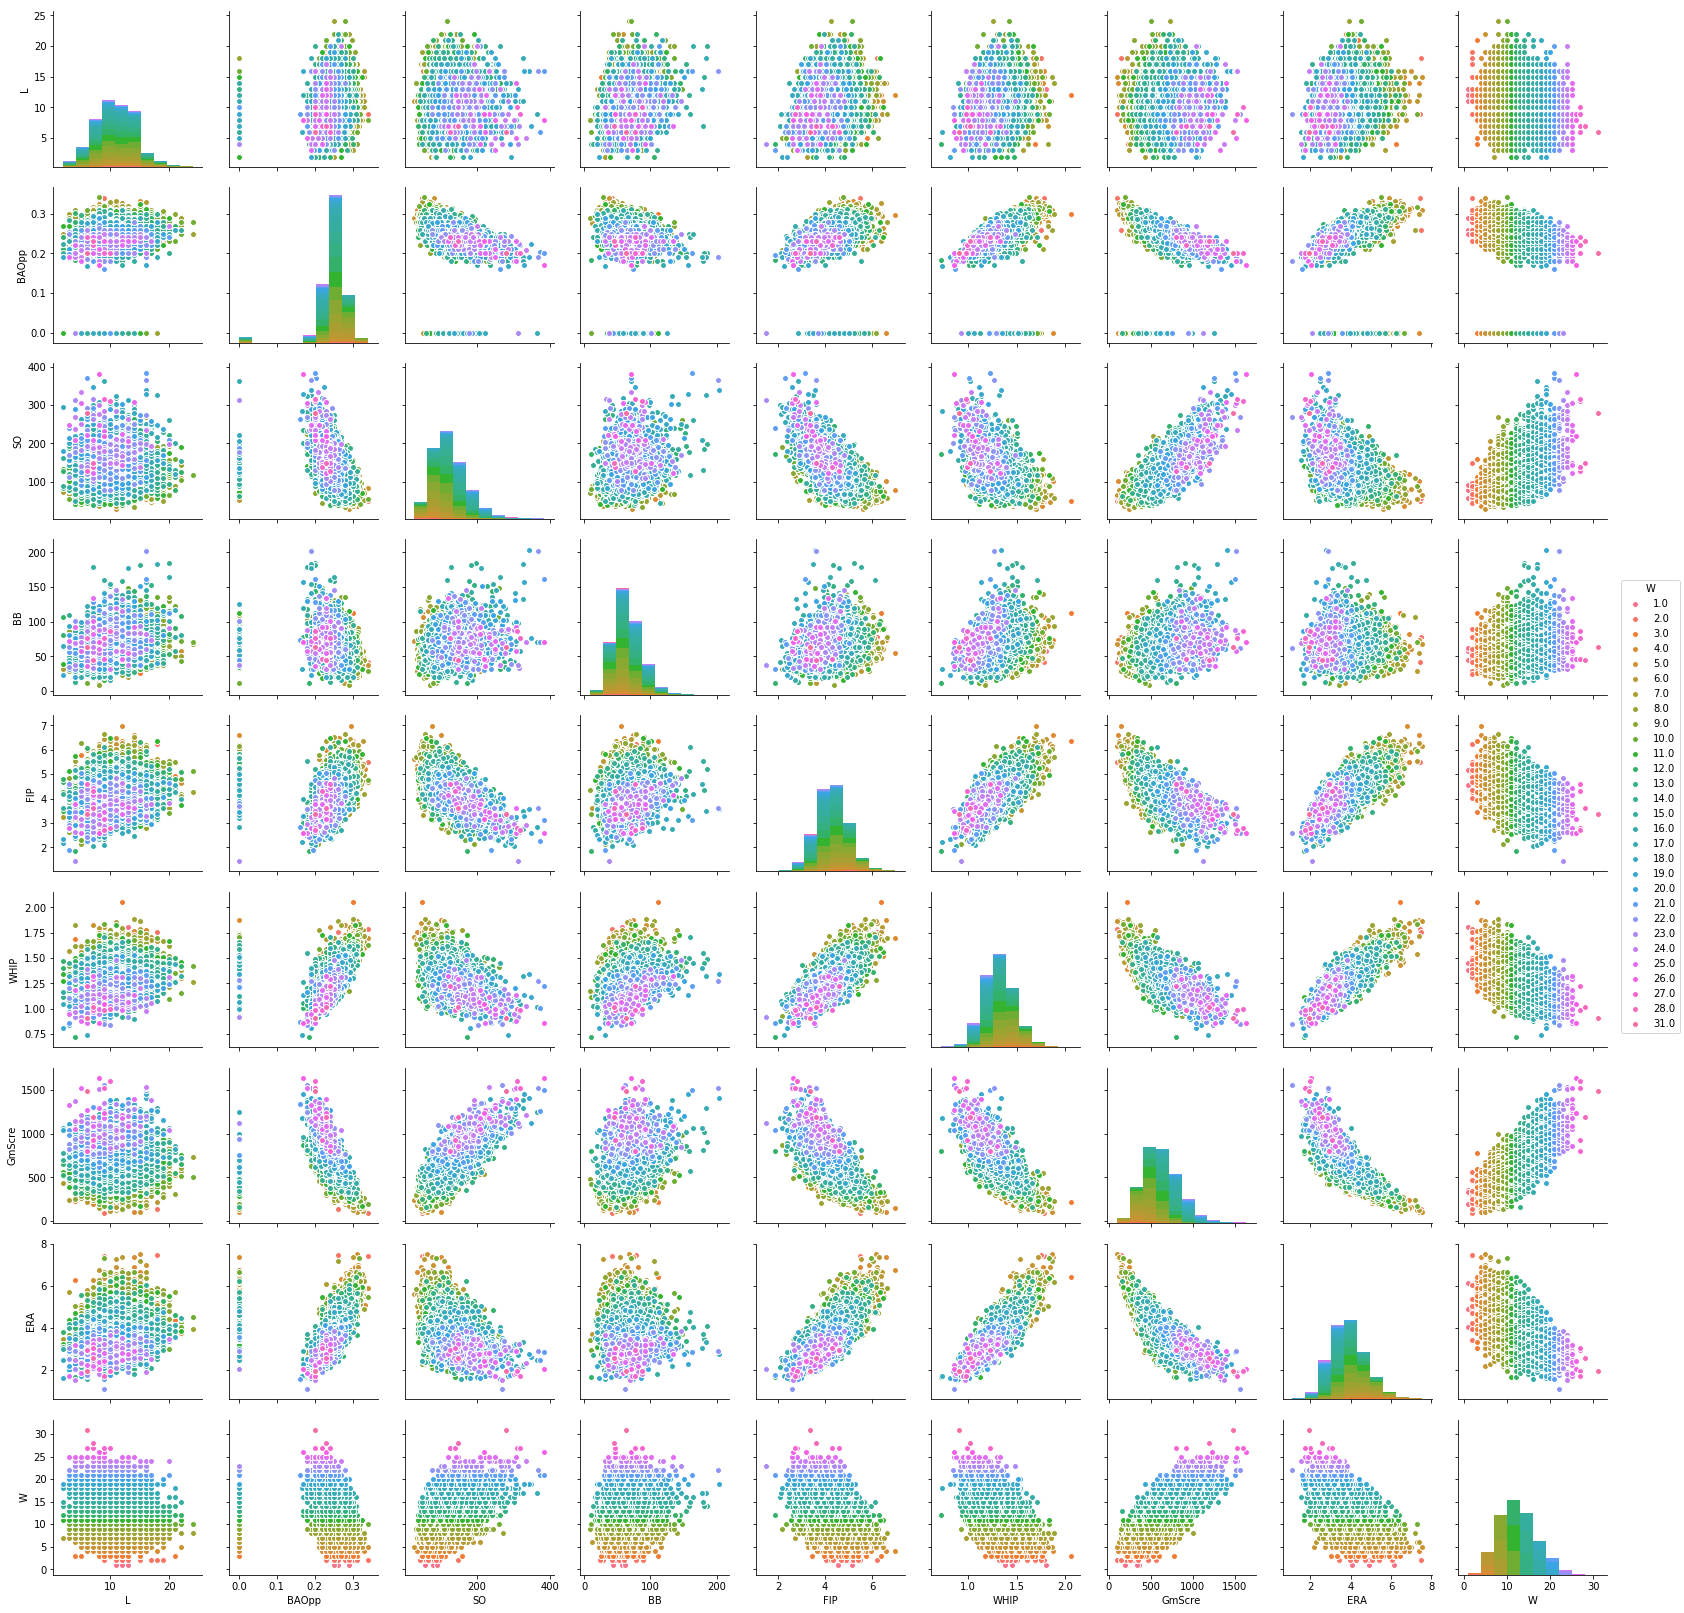

In [8]:
# All Pitchers with more than 20 games started in a season
#df3 = starting pitchers who have started more than 20 games


df3 = df1.loc[(df1['GS'] > 20)]



g = sns.pairplot(data=df3[['L','BAOpp', 'SO', 'BB','FIP', 'WHIP', 'GmScre', 'ERA', 'W']], hue='W', dropna=True)



/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


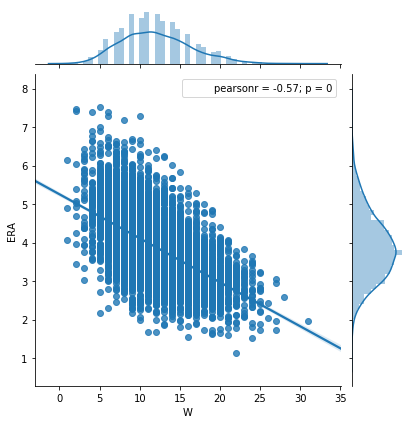

In [9]:
sns.jointplot(x="W", y="ERA", data=df3, kind = 'reg')


/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


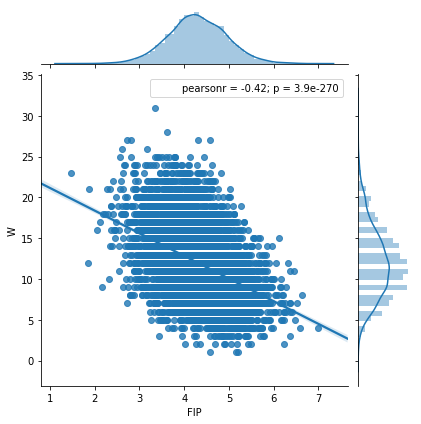

In [10]:
sns.jointplot(x="FIP", y="W", data=df3, kind = 'reg')


/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


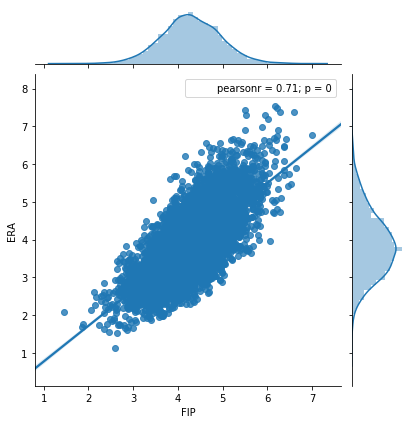

In [11]:
sns.jointplot(x="FIP", y="ERA", data=df3, kind = 'reg')


/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


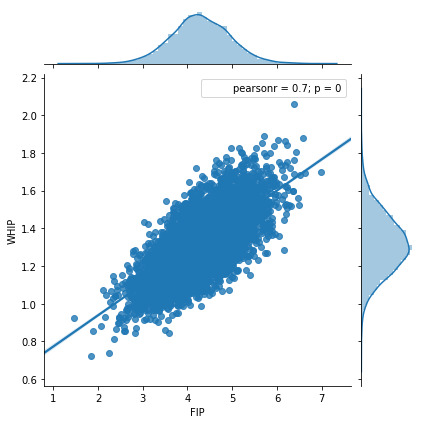

In [12]:
sns.jointplot(x="FIP", y='WHIP', data=df3, kind = 'reg')


/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


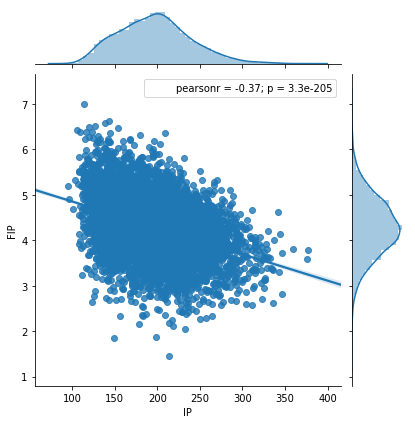

In [13]:
sns.jointplot(x="IP", y="FIP", data=df3, kind = 'reg')


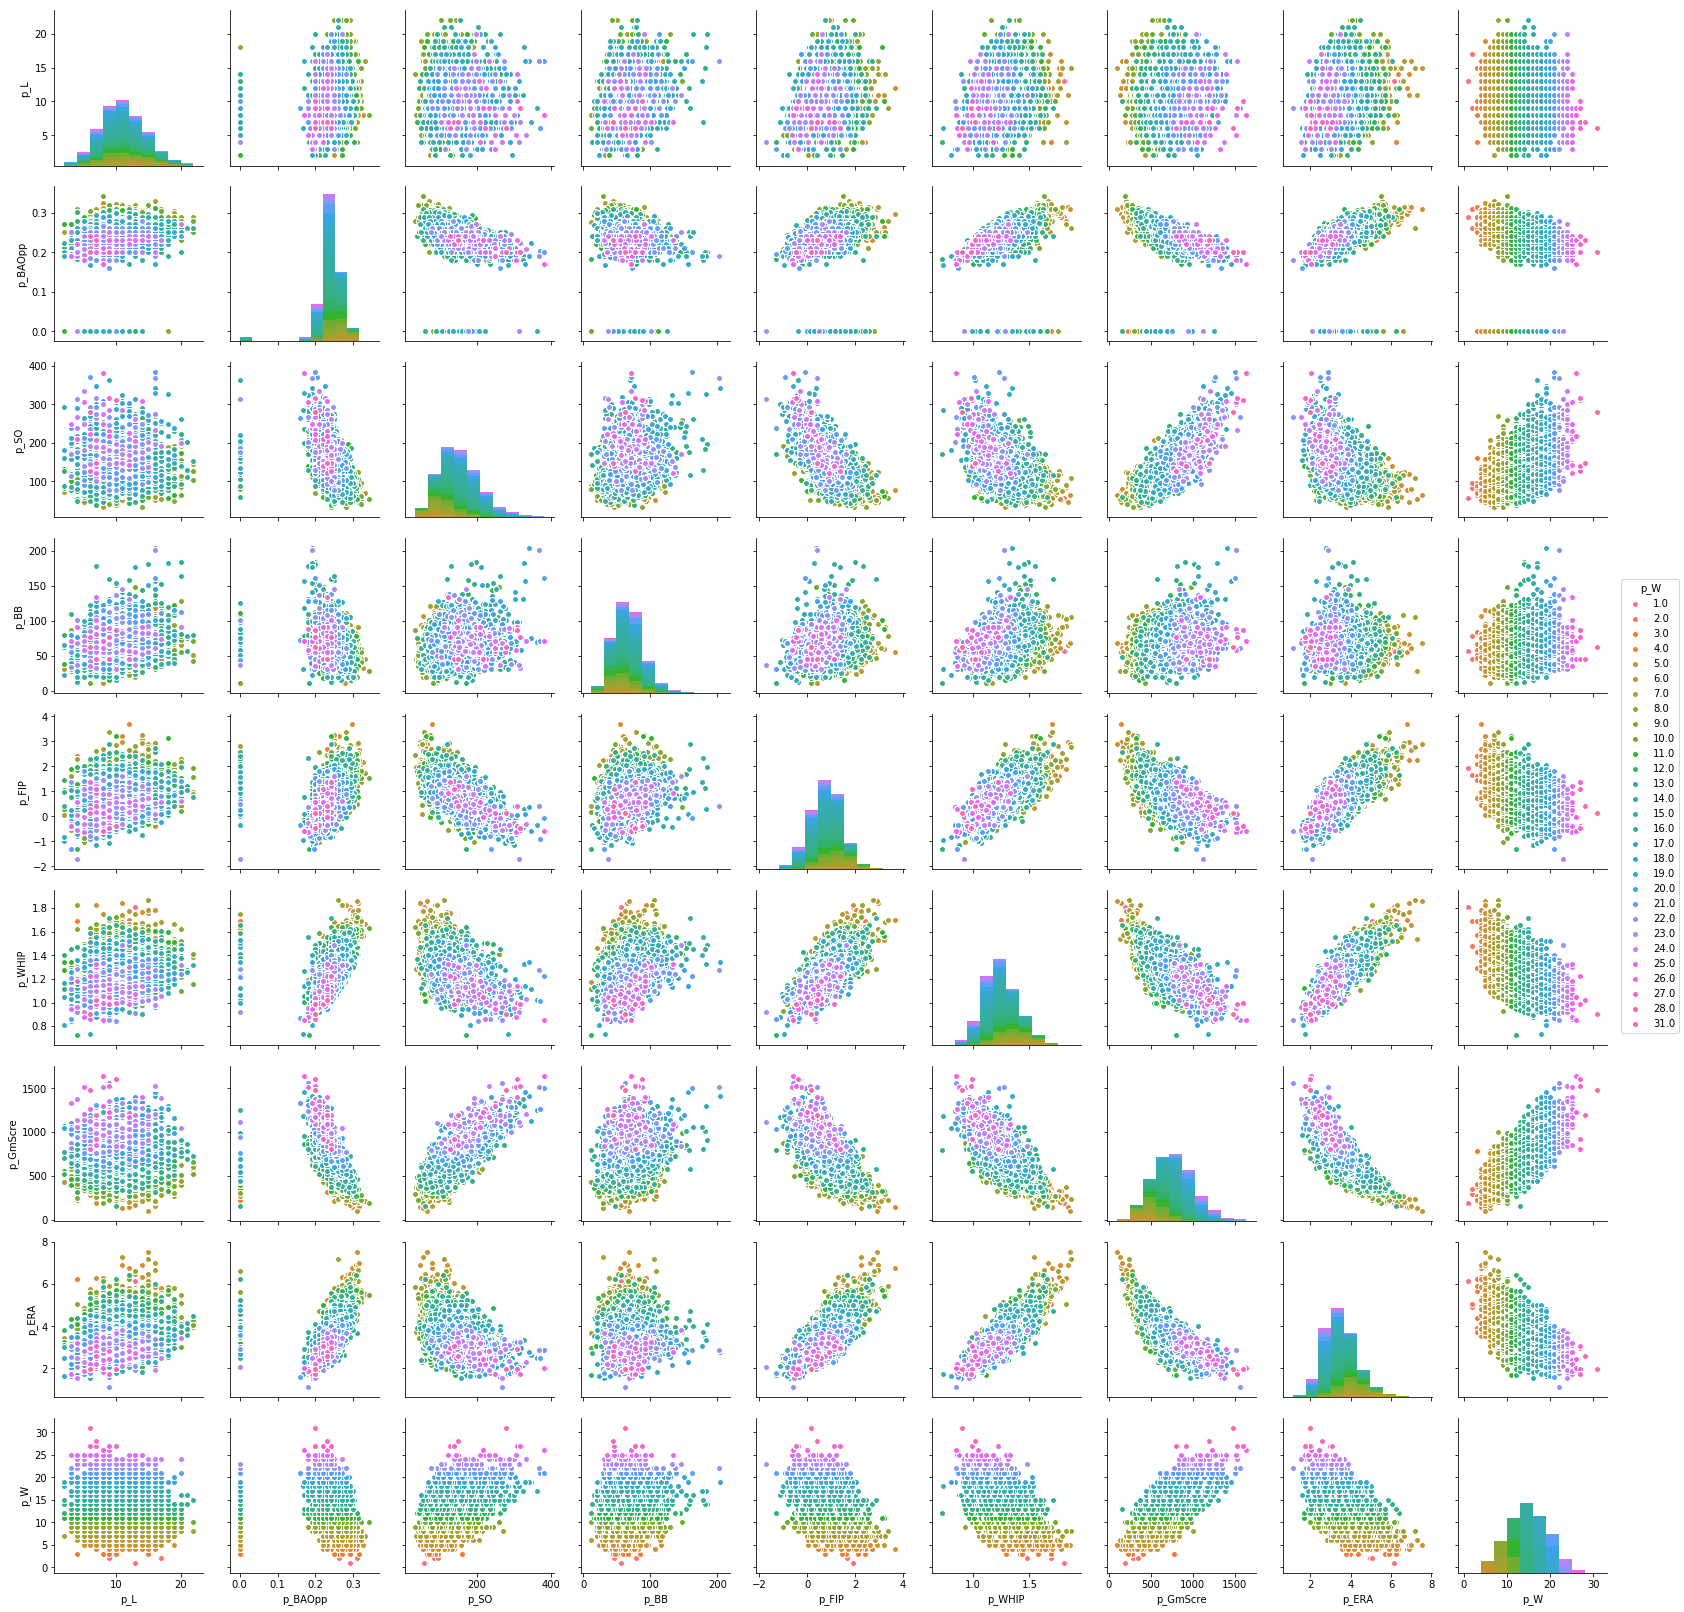

In [14]:
# All Star Pitchers with more than 20 games started
# df4 = All Star Pitchers with more than 20 games started 

df4 = df2.loc[(df2['p_GS'] > 20)]



g = sns.pairplot(data=df4[['p_L','p_BAOpp', 'p_SO', 'p_BB','p_FIP', 'p_WHIP', 'p_GmScre', 'p_ERA', 'p_W']], hue='p_W', dropna=True)

/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


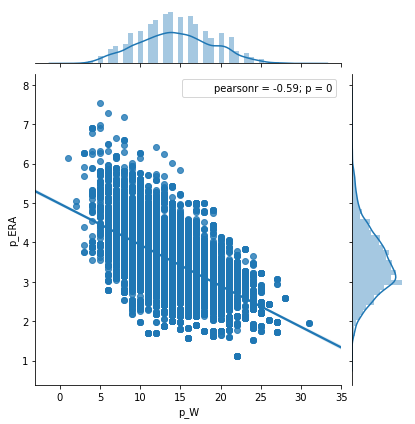

In [15]:
sns.jointplot(x="p_W", y="p_ERA", data=df4, kind = 'reg')


/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


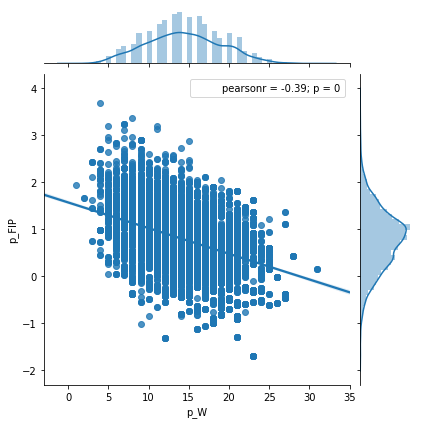

In [16]:
sns.jointplot(x="p_W", y="p_FIP", data=df4, kind = 'reg')


/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


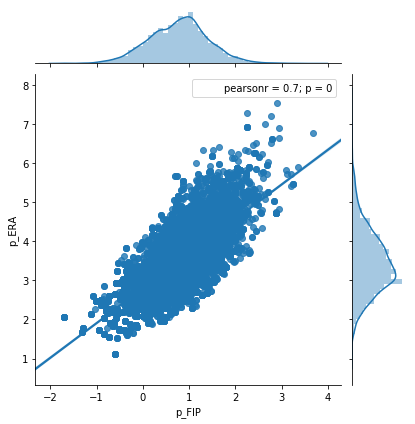

In [17]:
sns.jointplot(x="p_FIP", y="p_ERA", data=df4, kind = 'reg')


/Users/md1265/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/md1265/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


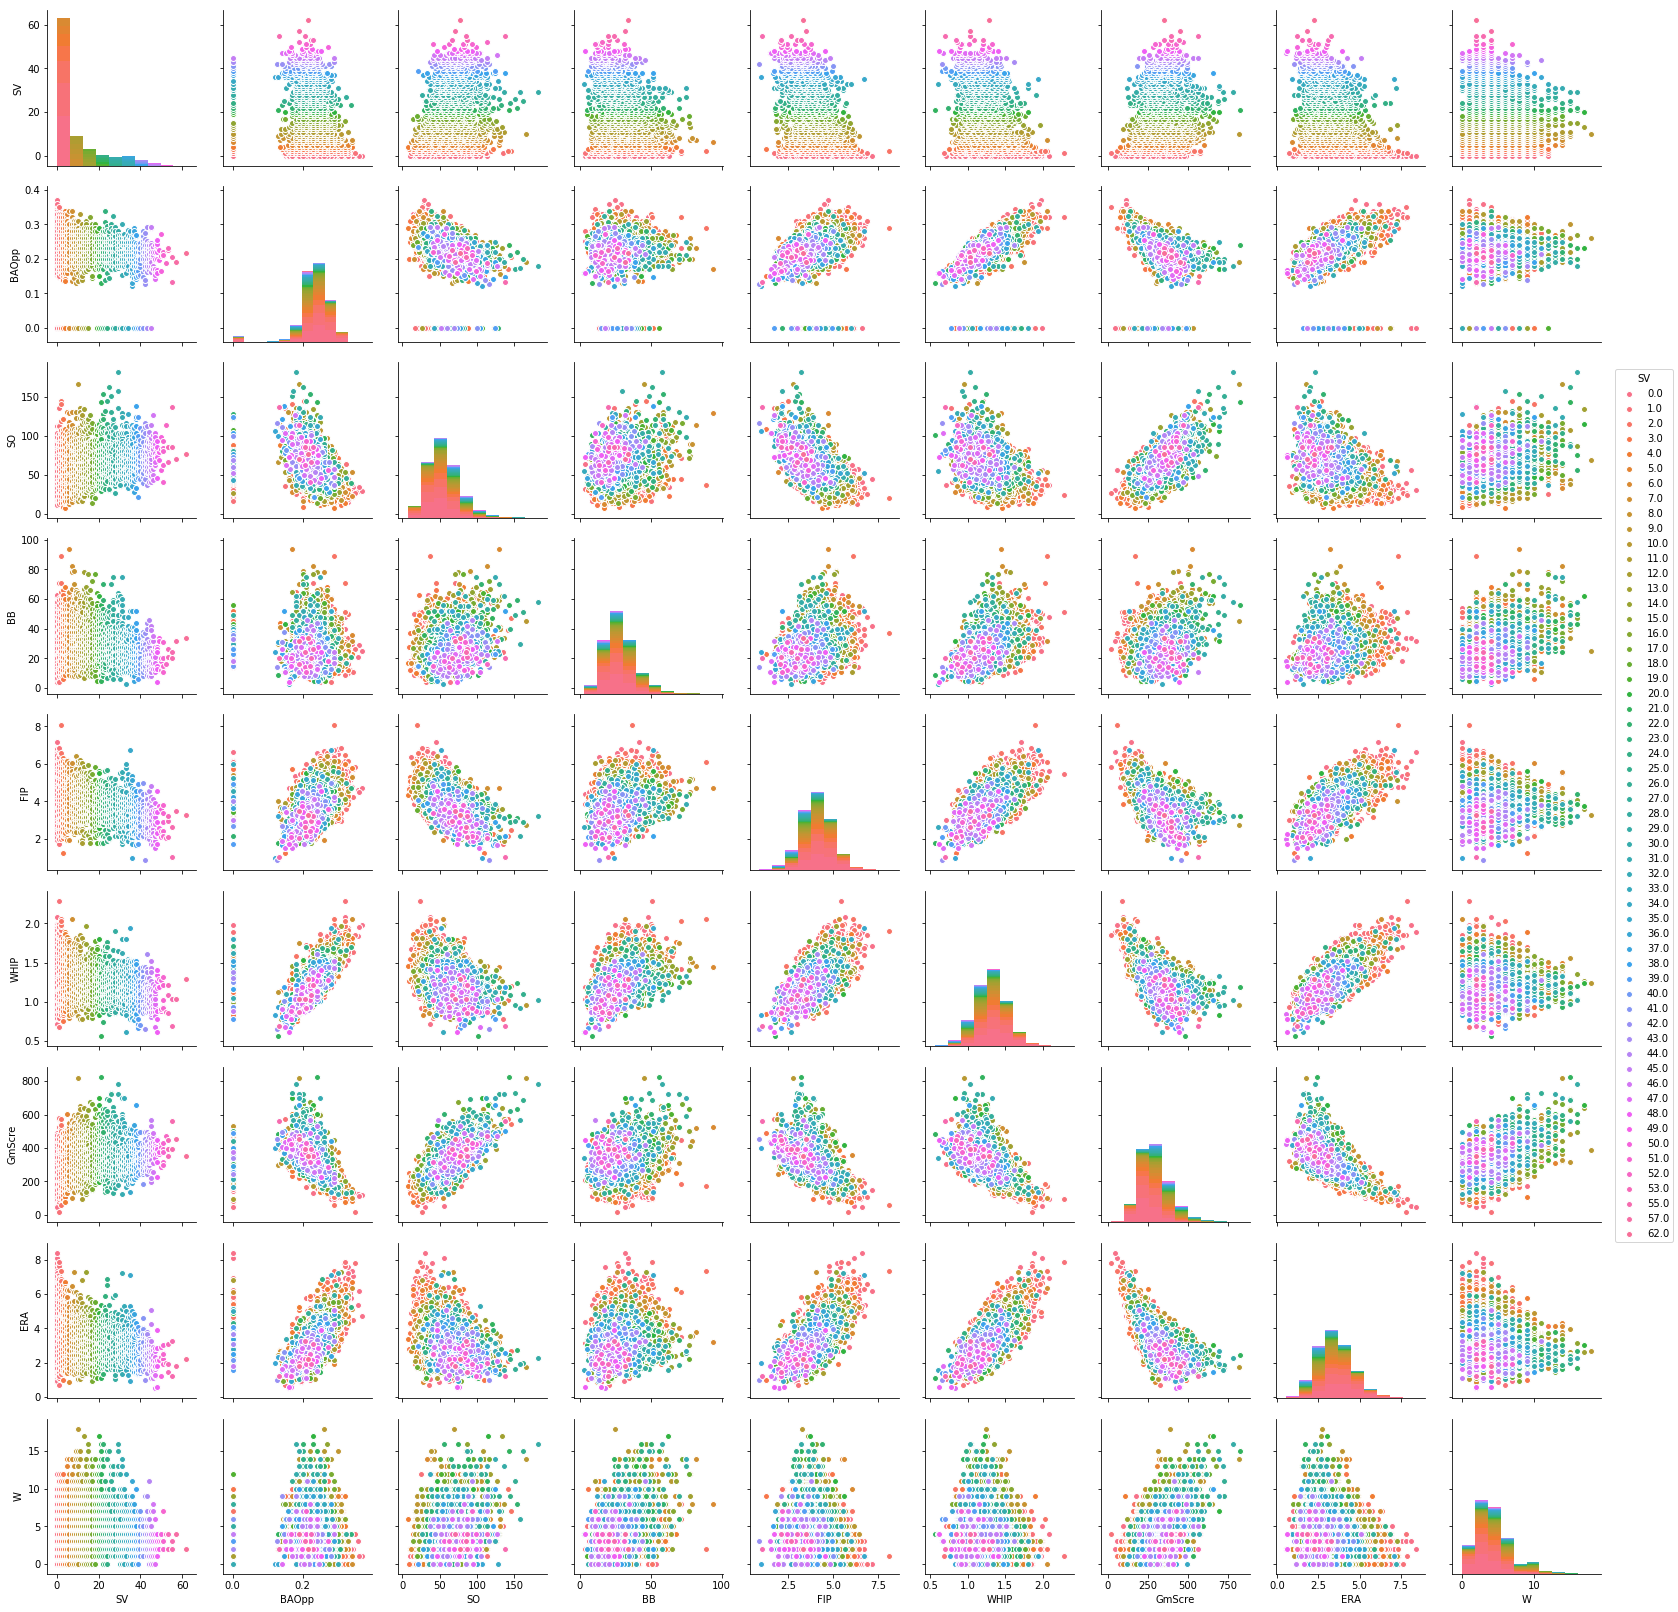

In [18]:
# df5 = releif pitchers - less than 5 "Games Started" and 
# more than 50 Innings pitched (> 150 IPOuts)

df99 = df1.loc[df1['GS'] < 5]
df5 = df99.loc[df99['IPouts'] > 150]

g = sns.pairplot(data=df5[['SV','BAOpp', 'SO', 'BB','FIP', 'WHIP', 'GmScre', 'ERA', 'W']], hue='SV', dropna=True)




/Users/md1265/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/md1265/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


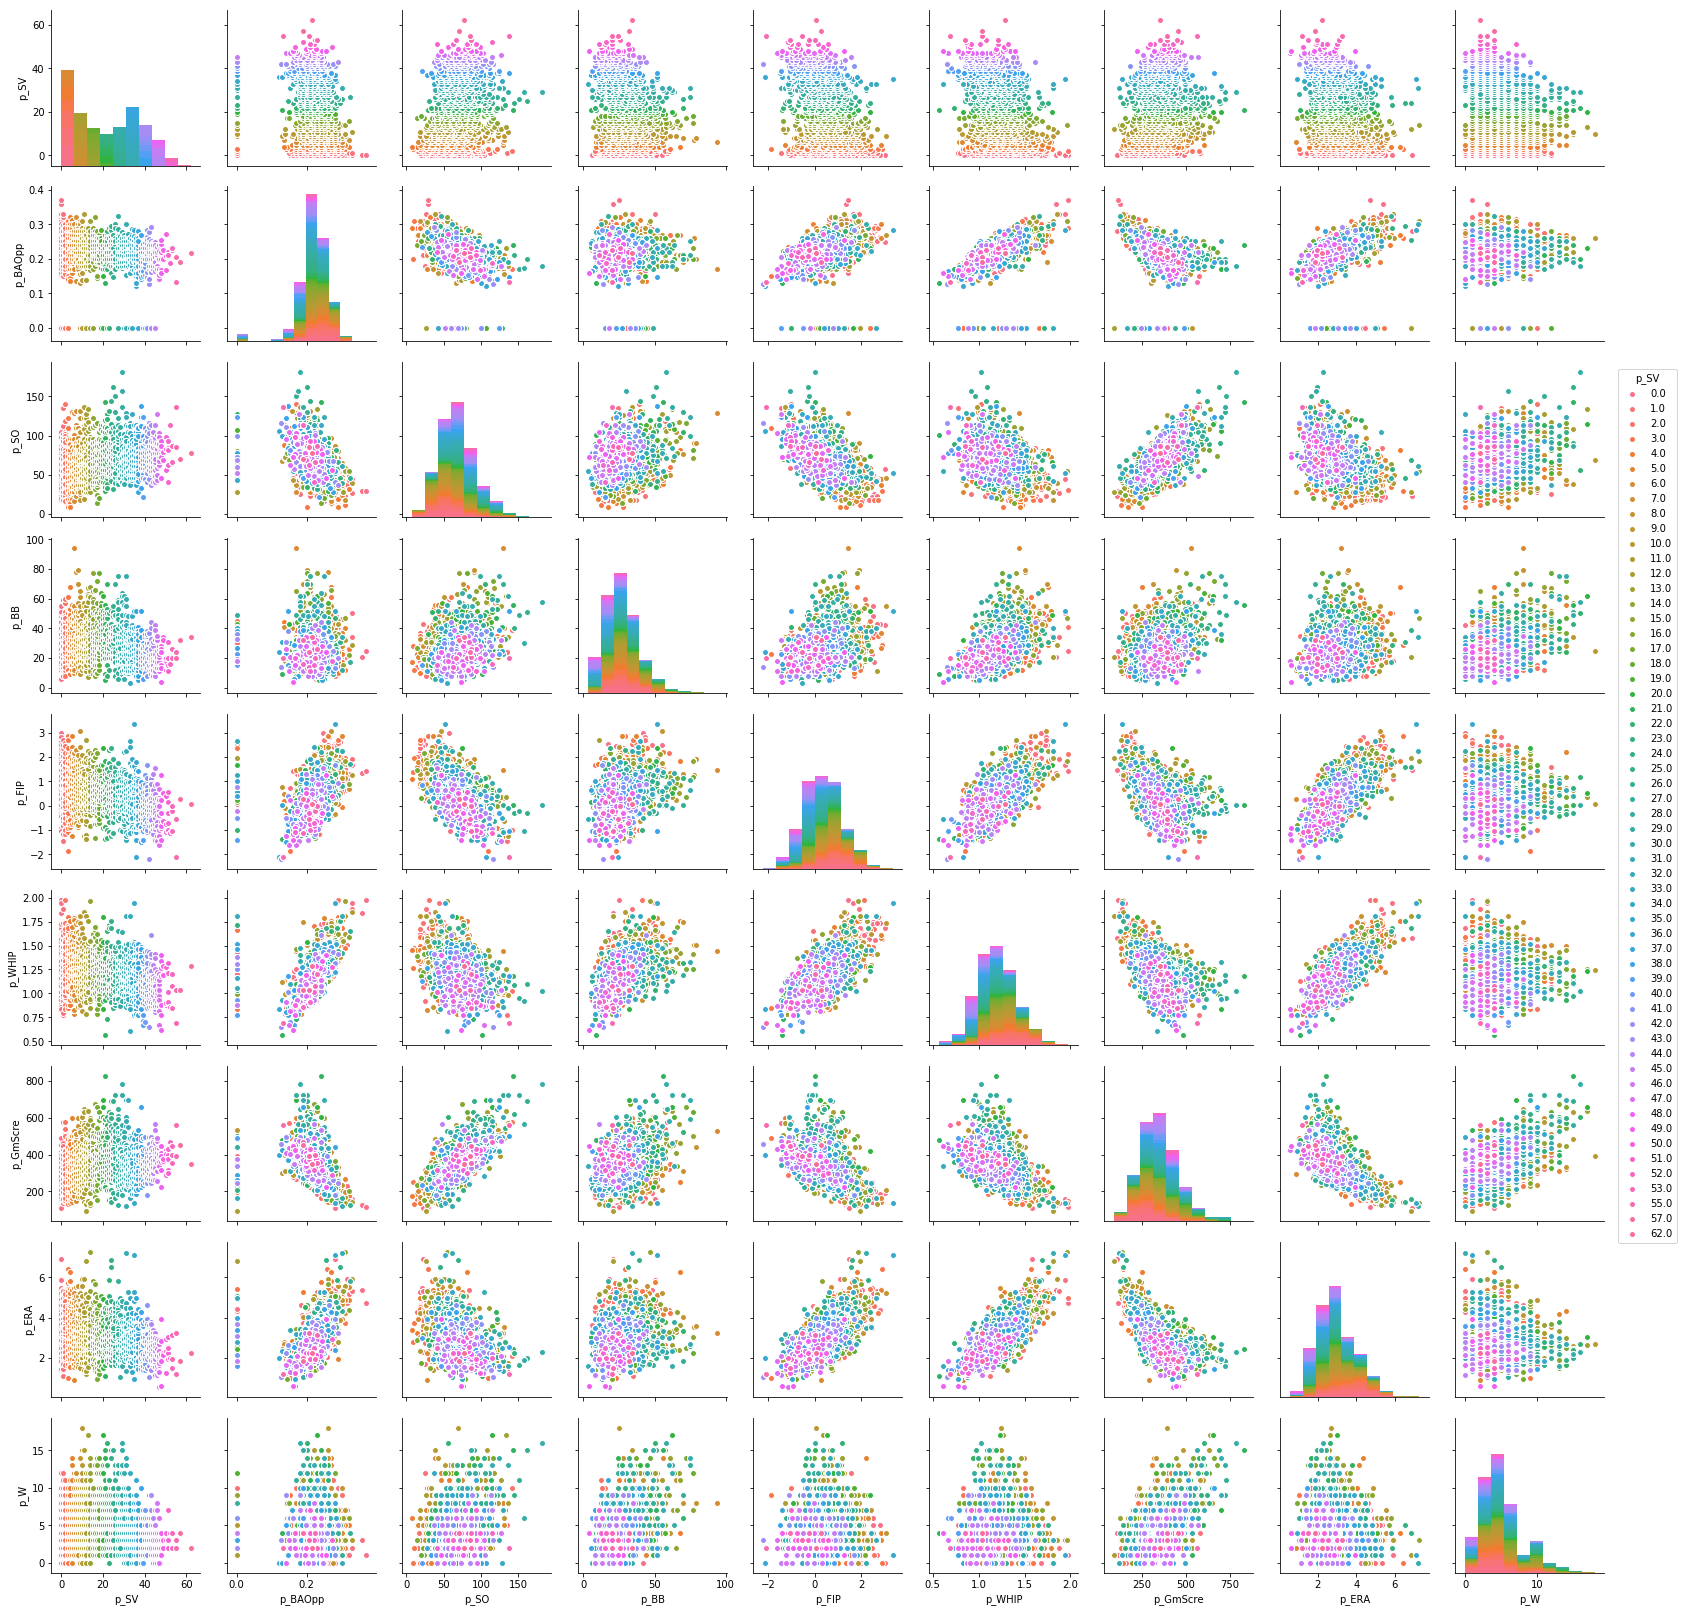

In [19]:
# df6 = All-Star releif pitchers - less than 5 "Games Started" and 
# more than 50 Innings pitched (> 150 IPOuts)

df98 = df2.loc[df2['p_GS'] < 5]
df6 = df98.loc[df98['p_IPouts'] > 150]

g = sns.pairplot(data=df6[['p_SV','p_BAOpp', 'p_SO', 'p_BB','p_FIP', 'p_WHIP', 'p_GmScre', 'p_ERA', 'p_W']], hue='p_SV', dropna=True)


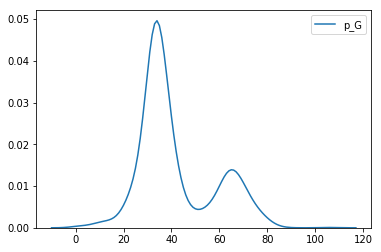

In [12]:
sns.kdeplot(df['p_G'].dropna())


/Users/md1265/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


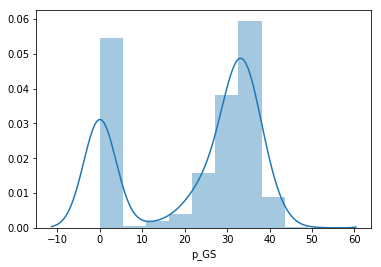

In [13]:
sns.distplot(df['p_GS'].dropna())